# KF EM RTS Nomoto

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.extended_kalman_filter import extended_kalman_filter, simulate, rts_smoother
import src.extended_kalman_filter as ekf
from src.visualization.plot import plot


import src.visualization.book_format as book_format
book_format.set_style()

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
def lambda_f_constructor(K, T_1):
    def lambda_f(x, input):
        delta = input["delta"]
        f = np.array([[x[1], (K * delta - x[1]) / T_1]]).T
        return f

    return lambda_f

In [3]:
np.random.seed(42)

T_1 = 1.8962353076056344
K = 0.17950970687951323
h = 0.02

lambda_f = lambda_f_constructor(K=K, T_1=T_1)

In [4]:
def do_simulation(h_, lambda_f, N_=4000):

    t_ = np.arange(0, N_ * h_, h_)

    us = np.deg2rad(
        np.concatenate(
            (
                -10 * np.ones(int(N_ / 4)),
                10 * np.ones(int(N_ / 4)),
                -10 * np.ones(int(N_ / 4)),
                10 * np.ones(int(N_ / 4)),
            )
        )
    )
    data = pd.DataFrame(index=t_)
    data["delta"] = us

    np.random.seed(42)
    E = np.array([[0, 1]]).T
    process_noise = np.deg2rad(0.01)
    ws = np.random.normal(scale=process_noise, size=N_)

    data["psi"] = 0
    data["r"] = 0
    df = simulate(data=data, lambda_f=lambda_f, E=E, ws=ws, state_columns=["psi", "r"])

    measurement_noise = np.deg2rad(0.5)
    df["epsilon"] = measurement_noise * np.random.normal(size=N_)
    df["psi_measure"] = df["psi"] + df["epsilon"]
    df["psi_deg"] = np.rad2deg(df["psi"])
    df["psi_measure_deg"] = np.rad2deg(df["psi_measure"])
    df["delta_deg"] = np.rad2deg(df["delta"])

    return df

In [5]:
df = do_simulation(lambda_f=lambda_f, h_=h)
data = pd.DataFrame(index=df.index)
data['psi'] = df['psi_measure']
data['r'] = df['r']
data['delta'] = df['delta']

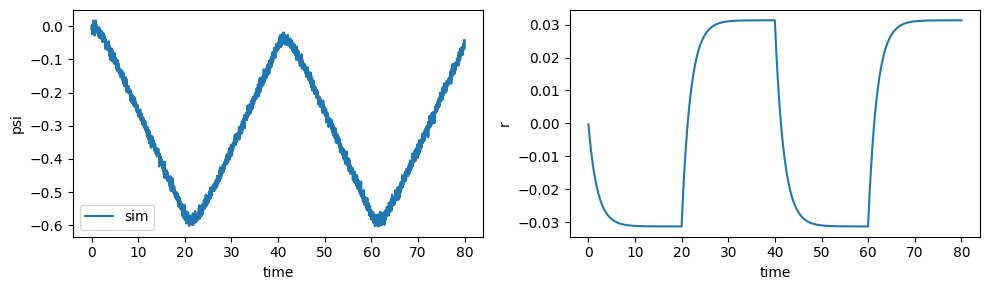

In [6]:
plot(dataframes={'sim':data}, keys=["psi",'r'], fig_size=(10,3));

In [7]:
P_prd = np.diag([np.deg2rad(1), np.deg2rad(0.1)])

Qd = np.deg2rad(np.diag([0.5]))

Rd = np.diag([np.deg2rad(1)])

E = np.array(
    [[0], [1]],
)

C_ = np.array([[1, 0]])

Cd = C_

In [8]:
def lambda_jacobian_constructor(h, K):
    def lambda_jacobian(x, input):

        delta = input["delta"]
        r = x[1]

        jac = np.array(
            [
                [1, h],
                [0, 1 - h / T_1],
            ]
        )
        return jac

    return lambda_jacobian

In [9]:
lambda_jacobian = lambda_jacobian_constructor(h=h, K=K)

In [10]:
state_columns = ['psi','r']
time_steps = extended_kalman_filter(no_states=2, 
                                    no_measurement_states=1, 
                                    P_prd=P_prd, 
                                    lambda_f=lambda_f, 
                                    lambda_jacobian=lambda_jacobian, 
                                    data=data, 
                                    Qd=Qd, 
                                    Rd=Rd, 
                                    E=E, 
                                    Cd=Cd, 
                                    state_columns = state_columns,
                                    measurement_columns=['psi'])

In [11]:
df_kalman = ekf.time_steps_to_df(time_steps, state_columns=state_columns)

In [12]:
time_steps_smooth = ekf.rts_smoother(
            time_steps=time_steps,
            lambda_jacobian=lambda_jacobian,
            Qd=Qd,
            lambda_f=lambda_f,
            E=E,
        )
df_smooth = ekf.time_steps_to_df(time_steps_smooth, state_columns=state_columns)

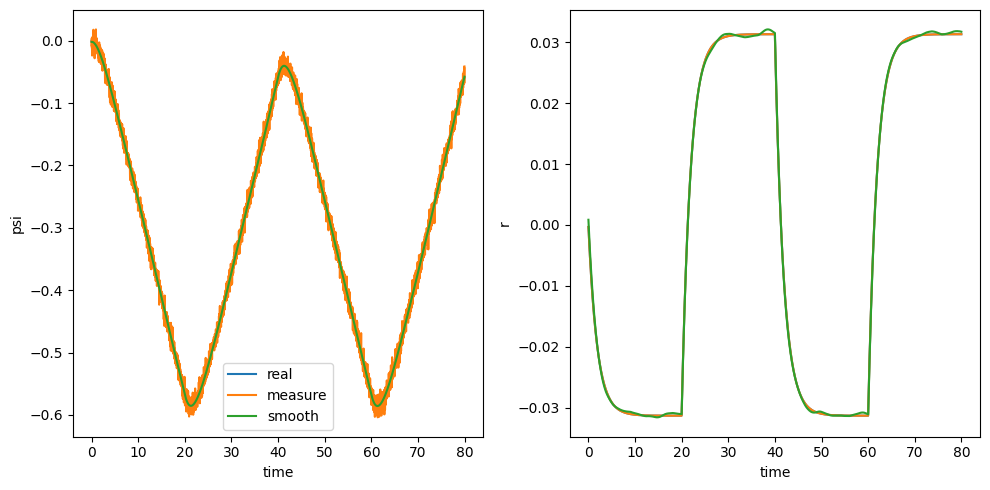

In [13]:
plot(dataframes={'real':df, 
                 'measure':data, 
                 #'kalman':df_kalman, 
                 'smooth':df_smooth}, 
                 keys=["psi",'r'], fig_size=(10,5));

## Parameter variation

In [14]:
def vary(K,T_1):
    
    # Vary:
    lambda_f = lambda_f_constructor(K=K, T_1=T_1)
    lambda_jacobian = lambda_jacobian_constructor(h=h, K=K)
    
    # Kalman filter:
    time_steps = extended_kalman_filter(no_states=2, 
                                    no_measurement_states=1, 
                                    P_prd=P_prd, 
                                    lambda_f=lambda_f, 
                                    lambda_jacobian=lambda_jacobian, 
                                    data=data, 
                                    Qd=Qd, 
                                    Rd=Rd, 
                                    E=E, 
                                    Cd=Cd, 
                                    state_columns = state_columns,
                                    measurement_columns=['psi'])
    
    # RTS smoother:
    time_steps_smooth = ekf.rts_smoother(
            time_steps=time_steps,
            lambda_jacobian=lambda_jacobian,
            Qd=Qd,
            lambda_f=lambda_f,
            E=E,
        )
    
    return time_steps_smooth
    

In [36]:
T_1s = np.linspace(0.5*T_1, 1.5*T_1, 5)

time_steps_vary = {}
for T_1_ in T_1s:
    time_steps_vary[T_1_] = vary(K=K, T_1=T_1_)

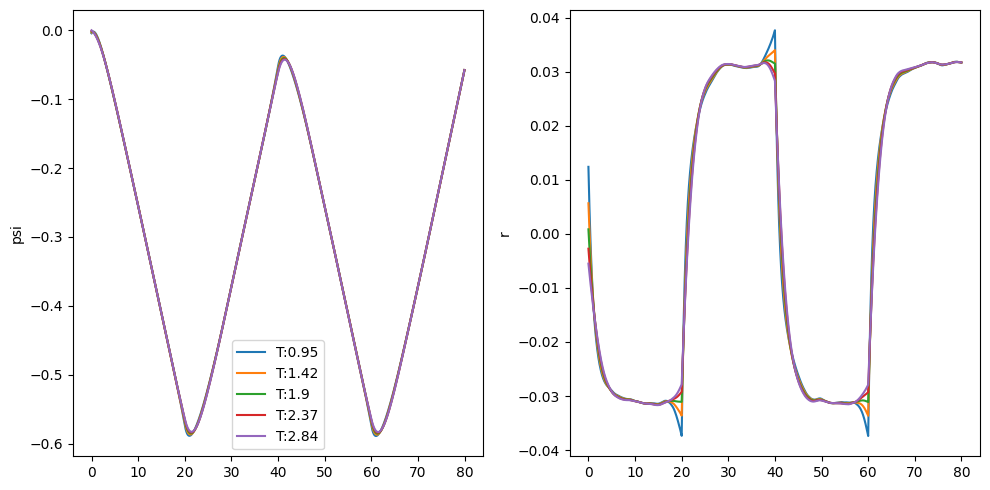

In [37]:
dataframes_vary = {f'T:{np.round(T_1_,2)}':ekf.time_steps_to_df(time_steps_, state_columns=state_columns) for T_1_,time_steps_ in time_steps_vary.items()}

plot(dataframes_vary, 
                 keys=["psi",'r'], fig_size=(10,5));
    
    

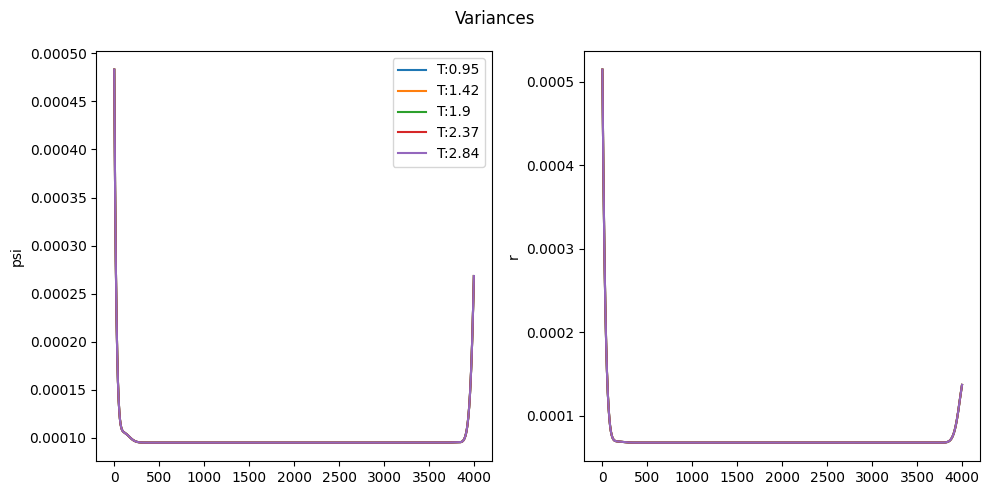

In [38]:
dataframes_vary_variances = {f'T:{np.round(T_1_,2)}':pd.DataFrame(ekf.variance(time_steps_).T, columns=state_columns) for T_1_,time_steps_ in time_steps_vary.items()}

fig = plot(dataframes_vary_variances, 
                 keys=["psi",'r'], fig_size=(10,5));
fig.suptitle('Variances');
plt.tight_layout()


In [39]:
from scipy.stats import multivariate_normal

def _loglikelihood(time_step):
    
    mean = time_step['x_hat'].flatten()
    cov = time_step['P_hat']
    rv = multivariate_normal(mean=mean, cov=cov)
    return rv.logpdf(mean)
    
    
def loglikelihood(time_steps):
    
    loglikelihood=0
    for time_step in time_steps:
        loglikelihood+=_loglikelihood(time_step)
        
    return loglikelihood


In [40]:
loglikelihood(time_steps)

27447.09974942184

In [41]:
loglikelihoods = np.zeros(len(time_steps_vary))
for i,(T_1_, time_steps_) in enumerate(time_steps_vary.items()):
    loglikelihoods[i] = loglikelihood(time_steps_)
    

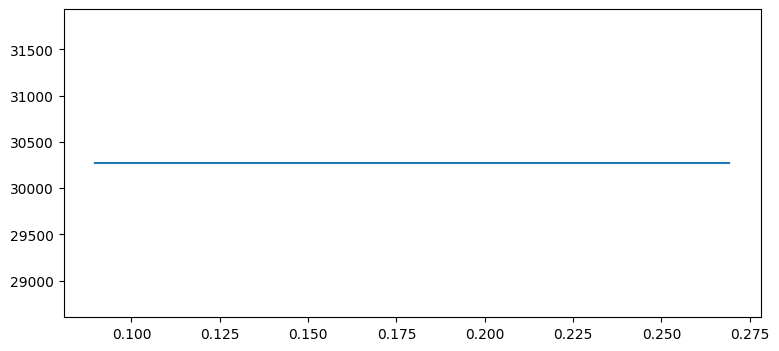

In [20]:
fig,ax=plt.subplots()
ax.plot(Ks, loglikelihoods)